# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

### Описание проекта

Заказчик этого исследования — сеть отелей «Как в гостях». \
    Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента. \
    Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

#### Бизнес-метрика и другие данные
Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. \
Стоимость номеров отеля:
- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150. 

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

### Шаг 1. Чтение файлов с данными

Импорт необходимых библиотек для анализа данных и прогнозирования

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder #энкодинг
from sklearn.preprocessing import StandardScaler #масштабирование
from sklearn.tree import DecisionTreeClassifier #дерево решений
from sklearn.ensemble import RandomForestClassifier #случайный лес
from sklearn.linear_model import LogisticRegression #логистическое решение
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from IPython.core.display import display, HTML
from IPython.display import display_html
import warnings
warnings.filterwarnings('ignore') 

STATE = np.random.RandomState(12345)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Чтение файлов

In [2]:
data_train = pd.read_csv('/datasets/hotel_train.csv')
data_test = pd.read_csv('/datasets/hotel_test.csv')

### Шаг 2. Предобработка и исследовательский анализ данных

Посмотрим, что из себя представляют данные с помощью метода info

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [4]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

Можем заметить, что размер обучающих и тестовых данных примерно соотносятся как 2:1 (65229:32412)

Посмотрим содержимое таблиц

In [5]:
display(data_train.head())
display(data_test.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


Заменим типы данных столбцов - 'id', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', поскольку эти столбцы не отражают количество, эти столбцы больше к качественным

Также нужно изменить типы данных столбцов 'lead_time', 'adults', 'children', 'babies' с типа числа с точкой на целочисленный

In [6]:
columns = ['id', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month']
for column in columns:
    data_train[column] = data_train[column].astype('str')
    data_test[column] = data_test[column].astype('str')
columns = ['lead_time', 'adults', 'children', 'babies']
for column in columns:
    data_train[column] = data_train[column].astype('int')
    data_test[column] = data_test[column].astype('int')

print(data_train.dtypes)
print('===============')
print(data_test.dtypes)

id                                object
is_canceled                        int64
lead_time                          int64
arrival_date_year                 object
arrival_date_month                object
arrival_date_week_number          object
arrival_date_day_of_month         object
stays_in_weekend_nights            int64
stays_in_week_nights               int64
adults                             int64
children                           int64
babies                             int64
meal                              object
country                           object
distribution_channel              object
is_repeated_guest                  int64
previous_cancellations             int64
previous_bookings_not_canceled     int64
reserved_room_type                object
booking_changes                    int64
days_in_waiting_list               int64
customer_type                     object
required_car_parking_spaces        int64
total_of_special_requests          int64
total_nights    

Типы данных скорректированы

Проверим данные на дубликаты

In [7]:
print('Кол-во дубликатов в обучающих данных:', data_train.duplicated().sum())
print('Кол-во дубликатов в тестовых данных:', data_test.duplicated().sum())

Кол-во дубликатов в обучающих данных: 0
Кол-во дубликатов в тестовых данных: 0


Удалим столбец 'id' и проверим ещё раз таблицы на дубликаты

In [8]:
d_train = data_train.drop(['id'], axis=1)
d_test = data_test.drop(['id'], axis=1)

print('Кол-во дубликатов в обучающих данных:', d_train.duplicated().sum())
print('Кол-во дубликатов в тестовых данных:', d_test.duplicated().sum())
# display(d_train)



Кол-во дубликатов в обучающих данных: 21377
Кол-во дубликатов в тестовых данных: 7717


In [9]:
d_train = d_train.drop_duplicates().reset_index(drop=True)
d_test = d_test.drop_duplicates().reset_index(drop=True)
print('Обучающая выборка')
print(
    f'Изначальное кол-во строк - {data_train.shape[0]}, удалено - {data_train.shape[0]-d_train.shape[0]}, стало - {d_train.shape[0]}'
)
print('Тестовая выборка')
print(
    f'Изначальное кол-во строк - {data_test.shape[0]}, удалено - {data_test.shape[0]-d_test.shape[0]}, стало - {d_test.shape[0]}'
)

Обучающая выборка
Изначальное кол-во строк - 65229, удалено - 21377, стало - 43852
Тестовая выборка
Изначальное кол-во строк - 32412, удалено - 7717, стало - 24695


Явных дубликатов обнаружены после удаления столбца 'id', возможно, пользователь несколько раз пытался внести свои данные, поскольку со столбцом 'id' дубликаты не обнаружены

В данных присутствуют столбцы, где могут закрасться неявные дубликаты, с типом данных 'object' - 'arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type'. Пример неявных дубликатов: Июль и July, A и a и т.п.

In [10]:
columns_object = ['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']
dfs = [d_train, d_test]

In [11]:
for df in dfs:
    print('===============')
    for column in columns_object:
        print('---------------')
        print(column)
        print(df[column].unique())

---------------
arrival_date_month
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
---------------
meal
['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']
---------------
country
['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC

Мы видим, что в обоих таблицах в столбце 'meal' есть оба неявных дубликата 'SC       ' и 'SC', а также содержатся лишние пробелы в столбцах 'meal' и 'reserved_room_type'

Создадим функцию, которая "убьёт сразу двух зайцев": уберёт лишние пробелы, тем самым пропадут неявные дубликаты

In [12]:
def delete_spaces(df, columns):
    for column in columns:
        df[column] = df[column].str.strip()
    return df

Вызовим эту функцию

In [13]:
column_spaces = ['meal', 'reserved_room_type']
d_train = delete_spaces(d_train, column_spaces)
d_test = delete_spaces(d_test, column_spaces)

Проверим, что получилось после удаления пробелов

In [14]:
dfs = [d_train, d_test]
for df in dfs:
    print('===============')
    for column in columns_object:
        print('---------------')
        print(column)
        print(df[column].unique())

---------------
arrival_date_month
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
---------------
meal
['BB' 'FB' 'HB' 'SC']
---------------
country
['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' '

Теперь исследуем данные на выбросы

In [15]:
display(d_train.describe())
display(d_test.describe())

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000
mean,0.254219,67.893779,0.896014,2.312141,1.856289,0.107589,0.010695,0.032929,0.041640,0.154748,0.249453,0.821354,0.082368,0.670847,3.208155
std,0.435426,73.990715,0.867677,1.454810,0.504892,0.397146,0.120050,0.178453,0.459333,1.583894,0.679791,9.902211,0.276086,0.802964,1.877202
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,9.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,41.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,103.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,1.000000,374.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000
mean,0.315246,88.834541,0.910306,2.379186,1.887265,0.106054,0.007208,0.040535,0.015104,0.223527,0.254343,0.341486,0.059567,0.763272,3.289492
std,0.464623,85.506551,0.859874,1.426038,0.495552,0.384630,0.086488,0.197213,0.206339,2.144022,0.698303,5.404491,0.247559,0.861233,1.818364
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,16.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,63.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
75%,1.000000,143.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,1.000000,373.000000,4.000000,6.000000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


In [16]:
def out_boxplot(dfs, columns):
    count_df = len(dfs)
    count_columns = len(columns)
    fig, axs = plt.subplots(nrows= count_df, ncols= count_columns, figsize = (20,15))
    fig.tight_layout(h_pad=2)
    for row in range(count_df):
         for column in range(count_columns):
#             print(columns[column])
            axs[row][column].boxplot(x=columns[column], data=dfs[row])
#             axs[row][column].hist(x=columns[column], data=dfs[row])
            axs[0][column].set_xlabel(columns[column])
            if row == 0:
                axs[row][0].set_ylabel('data_train')
            elif row == 1:
                axs[row][0].set_ylabel('data_test')
            

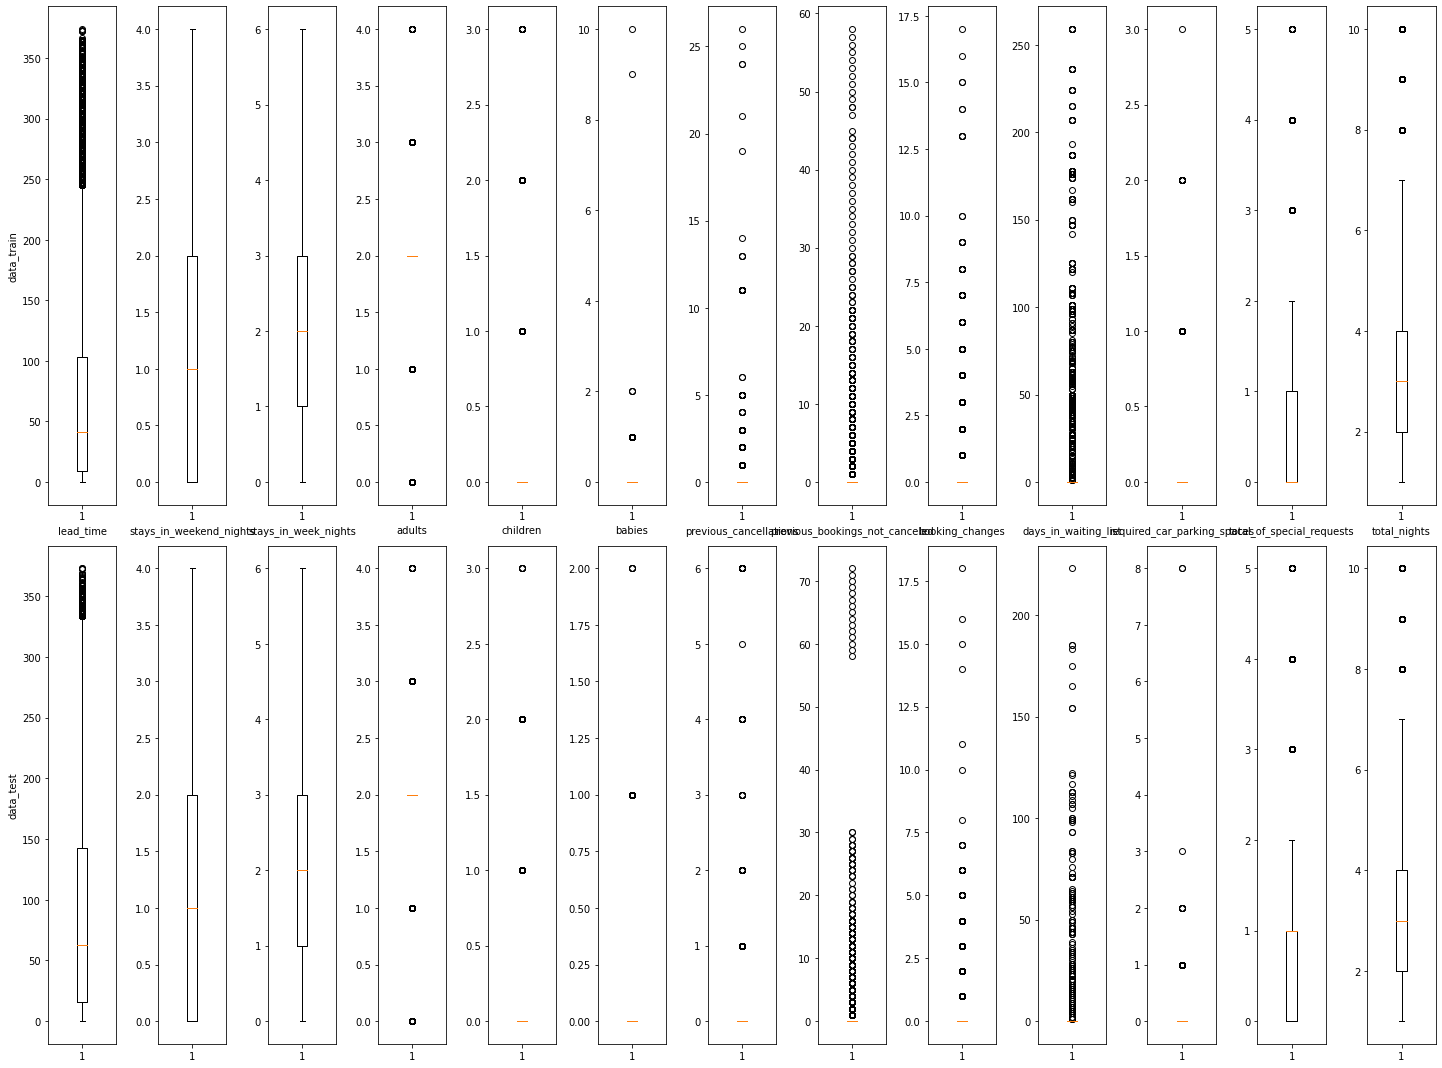

In [17]:
columns_numeric = d_test.columns.tolist()
columns_object = ['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type', 'is_canceled', 'is_repeated_guest']
for column in columns_object:
    columns_numeric.remove(column)
dfs = [d_train, d_test]

out_boxplot(dfs, columns_numeric)

Удалим строки с выбросами, для этого напишем функцию, которую потом вызовем

In [18]:
def df_process(df, columns):
    df_processed = df
    for column in columns:
        q25 = df_processed[column].quantile(.25)
        q75 = df_processed[column].quantile(.75)        
        q_min = q25 - 1.5*(q75-q25)
        q_max = q75 + 1.5*(q75-q25)
        df_processed = df_processed[df_processed[column] >= q_min]
        df_processed = df_processed[df_processed[column] <= q_max]
    return df_processed

Для удаления ненужных строк рассматриваем столбцы, где получился график в виде "ящика с усами" - 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'total_of_special_requests', 'total_nights'

In [19]:
need_columns = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'total_of_special_requests', 'total_nights']


df_train = df_process(d_train, need_columns).reset_index(drop=True)
df_test = df_process(d_test, need_columns).reset_index(drop=True)
print(f'Кол-во оставшихся строк df_train - {df_train.shape[0]}, удалено - {d_train.shape[0] - df_train.shape[0]}')
print(f'Кол-во оставшихся строк df_test - {df_test.shape[0]}, удалено - {d_test.shape[0] - df_test.shape[0]}')

Кол-во оставшихся строк df_train - 40666, удалено - 3186
Кол-во оставшихся строк df_test - 23238, удалено - 1457


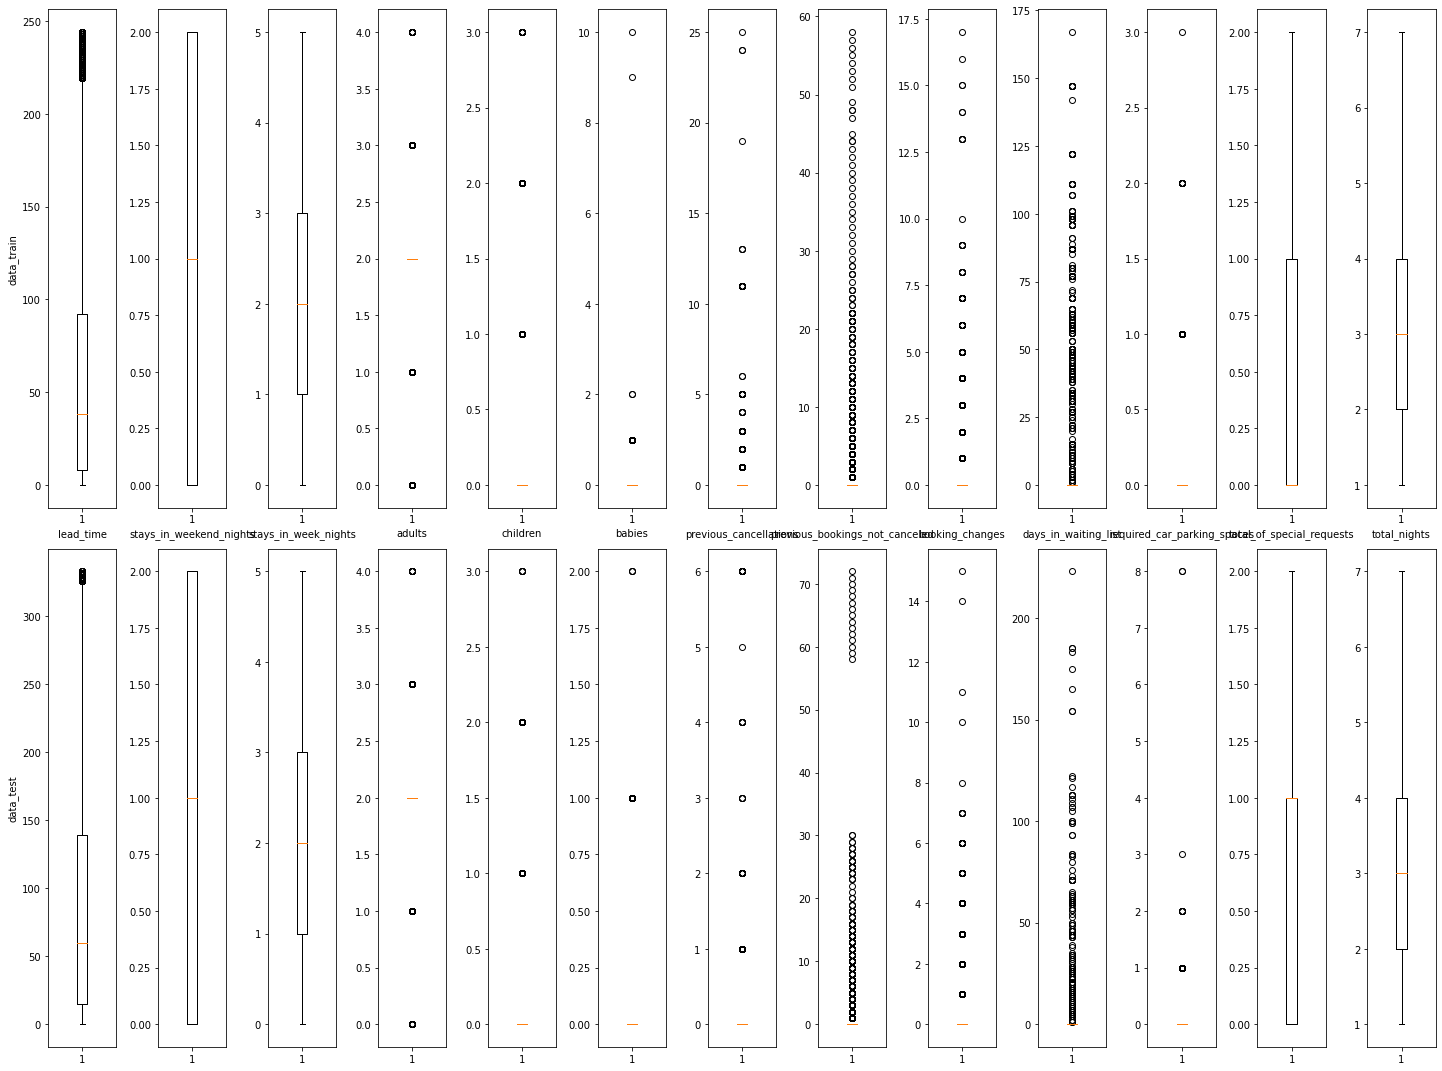

In [20]:
dfs = [df_train, df_test]

out_boxplot(dfs, columns_numeric)

Можем заметить, что 5% данных оказалось с выбросами, которые впоследствии удалились

Также нельзя учитывать записи о заездах без самих постояльцев, где кол-во взрослых постояльцев равно 0, т.е. по факту заезда не было, а запись в данные внесена 

In [21]:
hotel_train = df_train.query('adults > 0')
hotel_test = df_test.query('adults > 0')
print(f'Кол-во оставшихся строк hotel_train - {hotel_train.shape[0]}, удалено - {df_train.shape[0] - hotel_train.shape[0]}')
print(f'Кол-во оставшихся строк hotel_test - {hotel_test.shape[0]}, удалено - {df_test.shape[0] - hotel_test.shape[0]}')

Кол-во оставшихся строк hotel_train - 40519, удалено - 147
Кол-во оставшихся строк hotel_test - 23184, удалено - 54


In [22]:
print(hotel_train['arrival_date_year'].unique())
print(hotel_test['arrival_date_year'].unique())

['2015' '2016']
['2017']


In [23]:
display(hotel_test[['stays_in_week_nights', 'stays_in_weekend_nights', 'total_nights']].head())

,stays_in_week_nights,stays_in_weekend_nights,total_nights
0,0,1,1
1,2,2,4
2,2,2,4
3,5,2,7
4,5,2,7


Примечательно, что в обучающих данных представлены записи за 2015 и 2016 года, а в тестовых - за 2017, чем и объясняется разница между размерами в два раза в пользу первых, столбцы с годами, неделями и днями можем удалить, оставим только месяцы, т.к. они могут исказить предсказания; также можно заметить столбец 'total_nights' - сумма столбцов 'stays_in_week_nights' и 'stays_in_weekend_nights', поэтому удалим вторые столбцы

In [24]:
columns_delete = ['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_week_nights', 'stays_in_weekend_nights']
hotel_train_0 = hotel_train.drop(columns_delete, axis=1)
hotel_test_0 = hotel_test.drop(columns_delete, axis=1)
#Выведем, что получилось после удаления столбцов
display(hotel_train_0.head())
display(hotel_test_0.head())

,is_canceled,lead_time,arrival_date_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7,July,1,0,0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,0,14,July,2,0,0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,0,0,July,2,0,0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,0,9,July,2,0,0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,1,85,July,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


,is_canceled,lead_time,arrival_date_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,1,74,January,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,1,62,January,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,1,71,January,1,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,1,172,January,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7
4,1,52,January,1,0,0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,7


### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Оценим прибыль отеля без внедрения депозитов

У нас есть вводные данные:

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

**Стоимость номеров отеля:**
- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

Анализ будем производить на тестовых данных с необходимыми столбцами для вычисления прибыли/убытка - 'arrival_date_month', 'is_canceled', 'reserved_room_type', 'total_nights'

In [25]:
analis_columns = ['arrival_date_month', 'is_canceled', 'reserved_room_type', 'total_nights']
hotel_profit = hotel_test_0[analis_columns]
display(hotel_profit.head())
display(hotel_profit.shape)

,arrival_date_month,is_canceled,reserved_room_type,total_nights
0,January,1,A,1
1,January,1,A,4
2,January,1,A,4
3,January,1,A,7
4,January,1,A,7


(23184, 4)

Определим уникальные значения месяцев, чтобы не писать лишние строчки далее

In [26]:
hotel_profit['arrival_date_month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

Создадим вспомогательные таблицы для их объединения с предыдущей таблицей: 
- с коэффициентами для её объединения с предыдущей таблицей по месяцу с созданием нового столбца - 'koeff' 
- с ценами за ночь, стоимостью по типу номеров с созданием нового столбца - 'price_per_night', 'service_price' 

In [27]:
koeff_df = pd.DataFrame({'arrival_date_month' : [month for month in hotel_profit['arrival_date_month'].unique()],
                          'koeff' : [1, 1, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4]})
hotel_for_profit = hotel_profit.merge(koeff_df, on='arrival_date_month', how='left')
room_price_df = pd.DataFrame({'reserved_room_type' : [type_room for type_room in sorted(hotel_profit['reserved_room_type'].unique())],
                         'price_per_night' : [1000, 800, 600, 550, 500, 450, 350],
                         'service_price' : [400, 350, 350, 150, 150, 150, 150]})
hotel_for_profit = hotel_for_profit.merge(room_price_df, on='reserved_room_type', how='left')
display(hotel_for_profit.head())
display(hotel_for_profit.shape)


,arrival_date_month,is_canceled,reserved_room_type,total_nights,koeff,price_per_night,service_price
0,January,1,A,1,1.0,1000,400
1,January,1,A,4,1.0,1000,400
2,January,1,A,4,1.0,1000,400
3,January,1,A,7,1.0,1000,400
4,January,1,A,7,1.0,1000,400


(23184, 7)

Теперь можем рассчитать прибыль или убыток в зависимости от отмены брони, для этого надо написать функцию, которая будет создавать новый столбец - 'profit' 

In [28]:
def profit_column(row):    
    if row['is_canceled'] == 1:
        income = 0
        expenses = row['service_price'] + (row['price_per_night'] * row['koeff'])
    elif row['is_canceled'] == 0:
        income = row['price_per_night'] * row['total_nights'] * row['koeff']
        expenses = row['service_price'] * (1 + row['total_nights'] // 2)
    profit = income - expenses
    return profit

In [29]:
hotel_for_profit['profit'] = hotel_for_profit.apply(profit_column, axis=1)
display(hotel_for_profit.head())

,arrival_date_month,is_canceled,reserved_room_type,total_nights,koeff,price_per_night,service_price,profit
0,January,1,A,1,1.0,1000,400,-1400.0
1,January,1,A,4,1.0,1000,400,-1400.0
2,January,1,A,4,1.0,1000,400,-1400.0
3,January,1,A,7,1.0,1000,400,-1400.0
4,January,1,A,7,1.0,1000,400,-1400.0


In [30]:
hotel_for_profit['profit'].sum()
print(f'Прибыль отеля - {int(hotel_for_profit["profit"].sum())} руб.')

Прибыль отеля - 29356830 руб.


Прибыль отеля за 2017 год (январь-август) составляет 29 356 830 руб.

### Шаг 4. Разработка модели ML

#### Подготовка данных для прогнозирования

Проведём кодирование признаков

In [58]:
# hotel_train_ohe = pd.get_dummies(hotel_train, drop_first=True)
# hotel_test_ohe = pd.get_dummies(hotel_test, drop_first=True)
# hotel_train = hotel_train.drop(['id'], axis=1)
# hotel_test = hotel_test.drop(['id'], axis=1)
# display(hotel_test.head())

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
print('до кодирования тренировочных данных')
display(hotel_train_0.head())
hotel_train_ordinal = pd.DataFrame(encoder.fit_transform(hotel_train_0), 
                                       columns=hotel_train_0.columns)
print('после')
display(hotel_train_ordinal.head())
# hotel_test_ordinal = encoder.fit_transform(hotel_test_0)
print('до кодирования тестовых данных')
display(hotel_test_0.head())
hotel_test_ordinal = pd.DataFrame(encoder.transform(hotel_test_0), columns=hotel_test_0.columns)
print('после')
display(hotel_test_ordinal.head())


до кодирования тренировочных данных


,is_canceled,lead_time,arrival_date_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7,July,1,0,0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,0,14,July,2,0,0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,0,0,July,2,0,0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,0,9,July,2,0,0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,1,85,July,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


после


,is_canceled,lead_time,arrival_date_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0.0,7.0,5.0,0.0,0.0,0.0,0.0,49.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1,0.0,14.0,5.0,1.0,0.0,0.0,0.0,49.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0
2,0.0,0.0,5.0,1.0,0.0,0.0,0.0,115.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0
3,0.0,9.0,5.0,1.0,0.0,0.0,1.0,115.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0
4,1.0,85.0,5.0,1.0,0.0,0.0,0.0,115.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0


до кодирования тестовых данных


,is_canceled,lead_time,arrival_date_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,1,74,January,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,1,62,January,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,1,71,January,1,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,1,172,January,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7
4,1,52,January,1,0,0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,7


после


,is_canceled,lead_time,arrival_date_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,1.0,74.0,4.0,1.0,0.0,0.0,0.0,115.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1,1.0,62.0,4.0,1.0,0.0,0.0,0.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,3.0
2,1.0,71.0,4.0,0.0,0.0,0.0,0.0,115.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,3.0
3,1.0,172.0,4.0,1.0,0.0,0.0,0.0,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0
4,1.0,52.0,4.0,0.0,0.0,0.0,0.0,36.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0


Разделим обучающие и тестовые данные на признаки и ответы

In [59]:
features_train = hotel_train_ordinal.drop(['is_canceled'], axis=1)
target_train = hotel_train_ordinal['is_canceled']
# display(hotel_train_ordinal)
features_test = hotel_test_ordinal.drop(['is_canceled'], axis=1)
target_test = hotel_test_ordinal['is_canceled']

Проведём масштабирование признаков

In [33]:
column_delete_numeric = ['stays_in_weekend_nights', 'stays_in_week_nights']
for column in column_delete_numeric:
    columns_numeric.remove(column)
numeric = columns_numeric

In [34]:
scaler = StandardScaler()
numeric = columns_numeric
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

#### Выбор лучшей модели на обучающей выборке с помощью кросс-валидации

*Обучим данные разными моделями и выберем лучшую из них на обучающей выборке*

Дерево решений

In [39]:
max_depth = 10

max_b_accuracy_tree = 0
best_depth_tree = 0
best_min_samples_split = 0
best_min_samples_leaf = 0
best_model_tree = None
for depth in range(1, max_depth+1):
    for split in range(1, 6):
        for leaf in range(1, 6):
            model = DecisionTreeClassifier(
                max_depth=depth, random_state=STATE, 
                class_weight='balanced', min_samples_split = split, min_samples_leaf = leaf)
            scores = cross_val_score(model, features_train, target_train, scoring='balanced_accuracy', cv=5)
            b_accuracy_tree = scores.mean()
            if b_accuracy_tree > max_b_accuracy_tree:
                max_b_accuracy_tree = b_accuracy_tree
                best_depth_tree = depth
                best_model_tree = model
                best_min_samples_split = split
                best_min_samples_leaf = leaf
        
print(f'max_b_accuracy_tree - {max_b_accuracy_tree}')
print(f'best_depth_tree - {best_depth_tree}')
print(f'best_min_samples_split - {best_min_samples_split}')
print(f'best_min_samples_leaf - {best_min_samples_leaf}')

max_b_accuracy_tree - 0.6774396835869085
best_depth_tree - 7
best_min_samples_split - 4
best_min_samples_leaf - 1


Случайный лес

In [44]:
max_b_accuracy_forest = 0
best_depth_forest = 0
best_est = 0
best_min_samples_split_forest = 0
best_min_samples_leaf_forest = 0
best_model_forest = None
for est in range(1, 151, 10):
    for depth in range(1, 10):
        for split in range(1, 5):
            for leaf in range(1, 5):
                model = RandomForestClassifier(max_depth=depth, random_state=STATE, 
                                               n_estimators=est, class_weight='balanced',
                                              min_samples_split = split, min_samples_leaf = leaf)
                scores = cross_val_score(model, features_train, target_train, scoring='balanced_accuracy', cv=5)
                b_accuracy_forest = scores.mean()

                if b_accuracy_forest > max_b_accuracy_forest:
                    max_b_accuracy_forest = b_accuracy_forest
                    best_est=est
                    best_model_forest = model
                    best_depth_forest = depth
                    best_min_samples_split_forest = split
                    best_min_samples_leaf_forest = leaf
        
print(f'max_b_accuracy_forest - {max_b_accuracy_forest}')
print(f'best_depth_forest - {best_depth_forest}')
print(f'best_est - {best_est}')
print(f'best_min_samples_split - {best_min_samples_split_forest}')
print(f'best_min_samples_leaf - {best_min_samples_leaf_forest}')

max_b_accuracy_forest - 0.6756477859151311
best_depth_forest - 5
best_est - 21
best_min_samples_split - 2
best_min_samples_leaf - 2


Логистическая регрессия

In [43]:
best_model_log = None
best_iter = 0
max_b_accuracy_log = 0

for iterat in range (100, 1001, 100):
    model = LogisticRegression(random_state=STATE, max_iter=iterat, class_weight='balanced')
# model.fit(features_train, target_train)
# predicted_valid = model.predict(features_valid)
    scores = cross_val_score(model, features_train, target_train, cv=5, scoring='balanced_accuracy')
    b_accuracy_log = scores.mean()
    if b_accuracy_log > max_b_accuracy_log:
        best_model_log = model
        max_b_accuracy_log = b_accuracy_log
        best_iter = iterat
# best_cross_score_log = f1_score(target_valid, predicted_valid)
print(f'max_b_accuracy_log - {max_b_accuracy_log}')
print(f'best_iter - {best_iter}')

max_b_accuracy_log - 0.6526368503656497
best_iter - 300


In [46]:
best_model_tree.fit(features_train, target_train) 
best_model_forest.fit(features_train, target_train)
best_model_log.fit(features_train, target_train)

predicted_train_tree = best_model_tree.predict(features_train)
predicted_train_forest = best_model_forest.predict(features_train)
predicted_train_log = best_model_forest.predict(features_train)



best_f1_tree = cross_val_score(best_model_tree, features_train, target_train, cv=5, scoring='f1').mean()
best_f1_forest = cross_val_score(best_model_forest, features_train, target_train, cv=5, scoring='f1').mean()
best_f1_log = cross_val_score(model, features_train, target_train, cv=5, scoring='f1').mean()

Выведем сводную таблицу с результатами качества моделей

In [47]:
data_cross_score = {'tree': [max_b_accuracy_tree, best_f1_tree],
                    'forest': [max_b_accuracy_forest, best_f1_forest], 
                    'log': [max_b_accuracy_log, best_f1_log]}
df_cross_score = pd.DataFrame(data=data_cross_score, index=['balanced_accuracy', 'f1_score'])
display(df_cross_score)

,tree,forest,log
balanced_accuracy,0.677440,0.675648,0.652637
f1_score,0.512201,0.466650,0.500771


Видно, что модель "дерево решений" показала себя лучше всего, с помощью кросс-валидации у неё самые высокие показатели f1_score - 0.512201 и balanced_accuracy - 0.67744

Для надежности выведем ROC-кривые, чтобы удостовериться, что модель "дерево решений" подходит для прогнозирования оттока постояльцев из отеля

Перед этим лучшие варианты моделей надо обучить, чтобы построить ROC-кривые

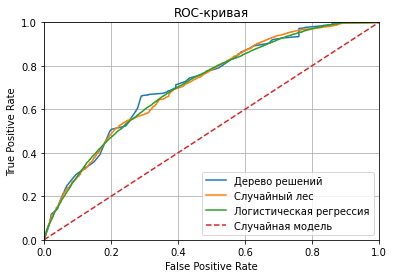

In [52]:
#Дерево решений
probabilities_train_tree = cross_val_predict(best_model_tree, features_train, target_train, cv=5, method='predict_proba')
probabilities_one_train_tree = probabilities_train_tree[:, 1]
fpr_tree, tpr_tree, thresholds_tree = roc_curve(target_train, probabilities_one_train_tree)

#Случайный лес
probabilities_train_forest = cross_val_predict(best_model_forest, features_train, target_train, cv=5, method='predict_proba')
probabilities_one_train_forest = probabilities_train_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(target_train, probabilities_one_train_forest) 

#Логистическая регрессия
probabilities_train_log = cross_val_predict(best_model_log, features_train, target_train, cv=5, method='predict_proba')
probabilities_one_train_log = probabilities_train_log[:, 1]
fpr_log, tpr_log, thresholds_log = roc_curve(target_train, probabilities_one_train_log) 

plt.figure()

# Графики
plt.plot(fpr_tree, tpr_tree)
plt.plot(fpr_forest, tpr_forest)
plt.plot(fpr_log, tpr_log)


# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

#Легенда графиков
plt.legend(['Дерево решений','Случайный лес','Логистическая регрессия', 'Случайная модель'])

# установка границ от до 1 по обеим осям
plt.xlim([-0.0,1.0])
plt.ylim([-0.0,1.0])

# подпись осей "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Название графика
plt.title('ROC-кривая')
plt.grid(True)

plt.show()

ROC-кривые показали, что все построенные модели качественные, т.к. все линии расположены выше ROC-кривой, т.е. площадь образованных под линией графика фигур значительно больше 0.5; также график подтверждает, что модель "дерево решений" больше подходит для прогнозирования отказа от брони с точки зрения качества.

Можем определить, сколько дохода модель "дерево решений"

По условию 

Чтобы привлечь клиентов, сеть отелей «Как в гостях» добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, чуть выше были разработаны разные модели, которые предсказывают отказ от брони. 

Нам нужно определить лучшую модель, которая предскажет отмененную бронь, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

Мы определили, что лучшей моделью является "дерево решений"

In [60]:
predicted_test_tree = best_model_tree.predict(features_test)
predicted_test_tree = pd.Series(predicted_test_tree)
# display(features_test.head())

In [61]:
def display_side_by_side(dfs:list, captions:list):
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [62]:
predicts = [predicted_test_tree]
models_name = ['Decision Tree']

for i in range(len(models_name)):
    FP = 0
    FN = 0
    TP = 0
    TN = 0
    predict_need = predicts[i]
    for j in range(len(target_test)):
        if predict_need[j] == target_test[j]:
            if predict_need[j] == 1:
                TP += 1
            elif predict_need[j] == 0:
                TN += 1
        if predict_need[j] != target_test[j]:
            if predict_need[j] == 1:
                FP += 1
            elif predict_need[j] == 0:
                FN += 1
    
    sum_pt = FP+FN+TP+TN
    predict_map = {'predict_0': [TN, FN], 'predict_1': [FP, TP]}
    df_predict_map = pd.DataFrame(data=predict_map, index=['target_0', 'target_1'])
    
    predict_map_per = (
        {'predict_0': ['{:.2%}'.format(TN/sum_pt), '{:.2%}'.format(FN/sum_pt)], 'predict_1': ['{:.2%}'.format(FP/sum_pt), '{:.2%}'.format(TP/sum_pt)]}
    )
    df_predict_map_per = pd.DataFrame(data=predict_map_per, index=['target_0', 'target_1'])
    print(models_name[i])
    
    df1_styler = df_predict_map.style.set_table_attributes("style='display:inline'").set_caption('Абсолютные значения')
    df2_styler = df_predict_map_per.style.set_table_attributes("style='display:inline'").set_caption('Относительные значения')
    display_html(df1_styler._repr_html_()+'|'+df2_styler._repr_html_(), raw=True)


Decision Tree


,predict_0,predict_1
target_0,11119,4694
target_1,4441,2930
,predict_0,predict_1
target_0,47.96%,20.25%
target_1,19.16%,12.64%


Добавим столбцы предсказаний в таблицу hotel_for_profit и выведем, что получилось

In [63]:
i_num = 0
predicts_columns = ['is_canceled_tree']
for column in predicts_columns:
    hotel_for_profit[column] = predicts[i_num]
    i_num += 1
display(hotel_for_profit.head())

,arrival_date_month,is_canceled,reserved_room_type,total_nights,koeff,price_per_night,service_price,profit,is_canceled_tree
0,January,1,A,1,1.0,1000,400,-1400.0,1.0
1,January,1,A,4,1.0,1000,400,-1400.0,0.0
2,January,1,A,4,1.0,1000,400,-1400.0,1.0
3,January,1,A,7,1.0,1000,400,-1400.0,0.0
4,January,1,A,7,1.0,1000,400,-1400.0,0.0


Для этого мы создадим функцию predicted_profit, аналогичную функции profit_column, но с измененными условиями в соответствии с текстом выше

In [64]:
def predicted_profit(row, col):    
    if row['is_canceled'] == 0:
        income = row['price_per_night'] * row['total_nights'] * row['koeff']
        expenses = row['service_price'] * (1 + row['total_nights'] // 2)
    elif row['is_canceled'] == 1:
        if row[col] == 0:
            income = 0
            expenses = row['service_price'] + (row['price_per_night'] * row['koeff'])            
        elif row[col] == 1:
            income = 0.8 * (row['service_price'] + (row['price_per_night'] * row['koeff']))
            expenses = row['service_price'] + (row['price_per_night'] * row['koeff'])
    profit = income - expenses
    return profit

In [65]:
profit_columns = ['profit_tree']
predicts_columns = ['is_canceled_tree']
for i in range(len(profit_columns)):
    col = profit_columns[i]
    hotel_for_profit[col] = hotel_for_profit.apply(lambda x: predicted_profit(x, col=predicts_columns[i]), axis=1)
display(hotel_for_profit.head())

,arrival_date_month,is_canceled,reserved_room_type,total_nights,koeff,price_per_night,service_price,profit,is_canceled_tree,profit_tree
0,January,1,A,1,1.0,1000,400,-1400.0,1.0,-280.0
1,January,1,A,4,1.0,1000,400,-1400.0,0.0,-1400.0
2,January,1,A,4,1.0,1000,400,-1400.0,1.0,-280.0
3,January,1,A,7,1.0,1000,400,-1400.0,0.0,-1400.0
4,January,1,A,7,1.0,1000,400,-1400.0,0.0,-1400.0


In [66]:
print('Прибыль после обучения DT:', hotel_for_profit['profit_tree'].sum())

Прибыль после обучения DT: 32889238.0


In [67]:
print('Полученная выгода от обучения DT:', hotel_for_profit['profit_tree'].sum() - hotel_for_profit['profit'].sum() - 400000)

Полученная выгода от обучения DT: 3132408.0


Данная разработанная система с помощью модели предсказания "Дерево решений" принесла дополнительную прибыль в размере - 3 132 408 руб. 

### Шаг 5. Описание портрета «ненадёжного» клиента

Добавим столбец 'is_canceled_tree' в таблицу hotel_test_0 из данных серии predicted_test_tree и выведем, что получилось

In [71]:
hotel_test_0['is_canceled_tree'] = predicted_test_tree
display(hotel_test_0.head())

,is_canceled,lead_time,arrival_date_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,is_canceled_tree
0,1,74,January,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1.0
1,1,62,January,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,0.0
2,1,71,January,1,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.0
3,1,172,January,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,0.0
4,1,52,January,1,0,0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,7,0.0


Теперь рассмотрим столбцы 'arrival_date_month', 'booking_changes', 'country', 'customer_type', 'meal', 'reserved_room_type', 'total_nights' по отдельности для составления портрета. Для этого сгруппируем данные по каждому столбцу, посчитаем количество уникальных значений, а также проведём сортировку по убыванию

In [81]:
df_real = hotel_test_0.query('is_canceled == 1').groupby('arrival_date_month')['is_canceled'].count().sort_values(ascending=False)
df_predict = hotel_test_0.query('is_canceled_tree == 1').groupby('arrival_date_month')['is_canceled_tree'].count().sort_values(ascending=False)

df_real = pd.DataFrame(df_real)
df_predict = pd.DataFrame(df_predict)

df1_styler = df_real.style.set_table_attributes("style='display:inline'").set_caption('Реальные значения')
df2_styler = df_predict.style.set_table_attributes("style='display:inline'").set_caption('Предсказанные значения')
display_html(df1_styler._repr_html_()+'|'+df2_styler._repr_html_(), raw=True)

,is_canceled
arrival_date_month,
May,1169
April,1132
June,1078
July,1007
August,907
March,787
February,717
January,574
,is_canceled_tree


По представленным данным можем сказать, что клиенты чаще всего отменяют свою бронь в мае.

In [82]:
df_real = hotel_test_0.query('is_canceled == 1').groupby('booking_changes')['is_canceled'].count().sort_values(ascending=False)
df_predict = hotel_test_0.query('is_canceled_tree == 1').groupby('booking_changes')['is_canceled_tree'].count().sort_values(ascending=False)

df_real = pd.DataFrame(df_real)
df_predict = pd.DataFrame(df_predict)

df1_styler = df_real.style.set_table_attributes("style='display:inline'").set_caption('Реальные значения')
df2_styler = df_predict.style.set_table_attributes("style='display:inline'").set_caption('Предсказанные значения')
display_html(df1_styler._repr_html_()+'|'+df2_styler._repr_html_(), raw=True)

,is_canceled
booking_changes,
0,6709
1,317
2,272
3,45
4,18
6,6
5,4
,is_canceled_tree
booking_changes,


Эти данные дают понять, что клиенты чаще всего отменяют свою бронь без изменений желаемого номера

In [83]:
df_real = hotel_test_0.query('is_canceled == 1').groupby('country')['is_canceled'].count().sort_values(ascending=False)
df_predict = hotel_test_0.query('is_canceled_tree == 1').groupby('country')['is_canceled_tree'].count().sort_values(ascending=False)

df_real = pd.DataFrame(df_real).head(10)
df_predict = pd.DataFrame(df_predict).head(10)

df1_styler = df_real.style.set_table_attributes("style='display:inline'").set_caption('Реальные значения')
df2_styler = df_predict.style.set_table_attributes("style='display:inline'").set_caption('Предсказанные значения')
display_html(df1_styler._repr_html_()+'|'+df2_styler._repr_html_(), raw=True)

,is_canceled
country,
PRT,1939
GBR,827
FRA,738
ESP,518
DEU,470
ITA,381
BRA,297
IRL,265
USA,204


Чаще всего отменяли брони граждане Пуэрто-Рико

In [84]:
df_real = hotel_test_0.query('is_canceled == 1').groupby('customer_type')['is_canceled'].count().sort_values(ascending=False)
df_predict = hotel_test_0.query('is_canceled_tree == 1').groupby('customer_type')['is_canceled_tree'].count().sort_values(ascending=False)

df_real = pd.DataFrame(df_real)
df_predict = pd.DataFrame(df_predict)

df1_styler = df_real.style.set_table_attributes("style='display:inline'").set_caption('Реальные значения')
df2_styler = df_predict.style.set_table_attributes("style='display:inline'").set_caption('Предсказанные значения')
display_html(df1_styler._repr_html_()+'|'+df2_styler._repr_html_(), raw=True)

,is_canceled
customer_type,
Transient,7072
Transient-Party,255
Contract,36
Group,8
,is_canceled_tree
customer_type,
Transient,6941
Transient-Party,552
Group,77


Постояльцы без договора на бронирование номера больше всез отменяют бронь

In [85]:
df_real = hotel_test_0.query('is_canceled == 1').groupby('meal')['is_canceled'].count().sort_values(ascending=False)
df_predict = hotel_test_0.query('is_canceled_tree == 1').groupby('meal')['is_canceled_tree'].count().sort_values(ascending=False)

df_real = pd.DataFrame(df_real)
df_predict = pd.DataFrame(df_predict)

df1_styler = df_real.style.set_table_attributes("style='display:inline'").set_caption('Реальные значения')
df2_styler = df_predict.style.set_table_attributes("style='display:inline'").set_caption('Предсказанные значения')
display_html(df1_styler._repr_html_()+'|'+df2_styler._repr_html_(), raw=True)

,is_canceled
meal,
BB,5194
SC,1629
HB,541
FB,7
,is_canceled_tree
meal,
BB,5707
SC,1419
HB,467


Постояльцы, которые бронировали номера с включенным завтраком в стоимость номера, отказывались чаще всех от заселения

In [90]:
df_real = hotel_test_0.query('is_canceled == 1').groupby('reserved_room_type')['is_canceled'].count().sort_values(ascending=False)
df_predict = hotel_test_0.query('is_canceled_tree == 1').groupby('reserved_room_type')['is_canceled_tree'].count().sort_values(ascending=False)

df_real = pd.DataFrame(df_real)
df_predict = pd.DataFrame(df_predict)

df1_styler = df_real.style.set_table_attributes("style='display:inline'").set_caption('Реальные значения')
df2_styler = df_predict.style.set_table_attributes("style='display:inline'").set_caption('Предсказанные значения')
display_html(df1_styler._repr_html_()+'|'+df2_styler._repr_html_(), raw=True)

,is_canceled
reserved_room_type,
A,4813
D,1732
E,447
F,152
G,109
C,81
B,37
,is_canceled_tree
reserved_room_type,


По выведенным данным, можно сказать, что постояльцы самих дорогих номеров отказывались от заселения

In [91]:
df_real = hotel_test_0.query('is_canceled == 1').groupby('total_nights')['is_canceled'].count().sort_values(ascending=False)
df_predict = hotel_test_0.query('is_canceled_tree == 1').groupby('total_nights')['is_canceled_tree'].count().sort_values(ascending=False)

df_real = pd.DataFrame(df_real)
df_predict = pd.DataFrame(df_predict)

df1_styler = df_real.style.set_table_attributes("style='display:inline'").set_caption('Реальные значения')
df2_styler = df_predict.style.set_table_attributes("style='display:inline'").set_caption('Предсказанные значения')
display_html(df1_styler._repr_html_()+'|'+df2_styler._repr_html_(), raw=True)

,is_canceled
total_nights,
3,1958
4,1564
2,1359
1,878
5,684
7,621
6,307
,is_canceled_tree
total_nights,


Клиенты, которые бронировали номера на 1-4 ночи, чаще всего отказывались от брони

Таким образом, можем составить **портрет "ненадежного" клиента**: месяц заезда - май, без изменений параметров заказа, гражданство - Пуэрто-Рико, без договора на бронирование номера, с включенным завтраком в стоимость номера, постояльцы самих дорогих номеров, бронь номера на 1-4 ночи 

### Шаг 6. Общий вывод

В данной работе разработана система, которая предсказывает отказ от брони, тем самым помогаю сети отелей «Как в гостях» снизить убытки.

В процессе работы были считаны оба файла: обучающие (за 2015-16 гг.) и тестовые (2017 г.) данные. 

На этапе их исследования 
- пропуски не обнаружены; 
- были замечены лишние пробелы в данных в столбцах 'reserved_room_type', 'meal', которые во втором указанном столбце образовывали пару неявных дубликатов 'SC ' и 'SC', впоследствии они были устранены с помощью функции delete_spaces;
- столбец 'id' был удалён из данных, т.к. они все уникальны, соответсвенно, далее были удалены все дубликаты уже без учёта удаленного столбца для корректного анализа данных; 
- с помощью функции out_boxplot были построены графики стоблцов с числовыми данными; далее были рассмотрены столбцы, где отобразился "ящик с усами", затем были удалены строки с выбивающимися значениями в этих столбцах
- в учёт брались бронирование номеров, где есть хотя бы один взрослый, т.к. дети не могут себе забронировать номера в отеле

Следующий этап заключался в расчёте прибыли/убытка сети отелей без внедрения депозитов, а именно: 
- анализ был на тестовых данных с необходимыми столбцами для вычисления прибыли/убытка - 'arrival_date_month', 'is_canceled', 'reserved_room_type', 'total_nights'
- были созданы вспомогательные таблицы для их объединения с таблицей, описанной чуть выше: 
1. с коэффициентами для её объединения с предыдущей таблицей по месяцу с созданием нового столбца - 'koeff', 
2. с ценами за ночь, стоимостью по типу номеров с созданием нового столбца - 'price_per_night', 'service_price'
- далее была создана функция profit_column с созданием нового столбца в таблице, который рассчитывал прибыль/убыток от брони
- в итоге была общая сумма прибыли/убытка сети отелей, она оказалась положительной, т.е. с прибылью в 29 356 830 руб

На третьем, самом важном, этапе предстояло разработать модели ML, которые предсказывали бы отмену брони. Перед этим пришлось провести т.н. "предобработку данных" для машинного обучения: порядковое кодирование данных и масштабирование данных. Без этих шагов почти нереально было бы обучить модели. Т.к. у нас целевой признак имеет значения 1 *(да)* и 0 *(нет)*, то в качестве моделей ML были использованы "Дерево решений" - "DecisionTreeClassifier", "Случайный лес" - "RandomForestClassifier", "Логистическое решение" - "LogisticRegression". Для каждой модели подбирались параметры, при которых метрика сбалансированного качества предсказаний *(balanced_accuracy)* через кросс-валидацию была максимальной, простыми из каждой модели отбиралась лучшая подмодель с лучшими параметрами. Вдобавок была использована метрика f1_score, которая сочитает в себе точность и полноту предсказаний, на этом основании была составлена таблица сравнений разных моделей с метриками balanced_accuracy и f1_score. В процессе сравнения и анализа было выяснено, что лучшей моделью является "дерево решений". Это подтвердили ROC-кривые.

Далее на тестовой выборке с помощью модели DT было проведено 
- предсказание отмены брони, 
- результаты предсказания были включены в таблицу, описанную на втором этапе, в качестве столбца 'is_canceled_tree'; 
- чуть позже была создана функция predicted_profit с созданием нового столбца в таблице, который рассчитывал предсказанный прибыль/убыток от брони 
- в итоге была высчитана общая сумма прибыли/убытка сети отелей после введения системы - 32 889 238 руб, выгода от модели - 3 132 408 руб.

Для более полной картины составлен портрет "ненадежного" клиента: месяц заезда - май, без изменений параметров заказа, гражданство - Пуэрто-Рико, без договора на бронирование номера, с включенным завтраком в стоимость номера, постояльцы самих дорогих номеров, бронь номера на 1-4 ночи
